# Machine Learning Project - Marketing Campaign
### Various ML Models to Predict Marketing Success
### Naive Bayes, Linear Regression, Random Forest, XGBoost
### Model Evaluation using ROC score and optimal threshold

**Dataset:**
Bank Marketing data:  https://archive.ics.uci.edu/ml/datasets/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

**Objective:** Given the marketing campaign, determine whether the client will subscribe or not. 

**Methods:**
  * Try 3 different types of models to make classification predictions on the bank marketing dataset 
  * Calculate the AUC score as a comparison, and at least 2 other metrics (ie: accuracy, F1 score, precision, recall, etc) 
      - Compare the models’ performance on the same train/test splits 
  * Plot the ROC curve from the best model, choose what the best threshold value is for making predictions

## Import Packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [3]:
# Read dataset to pandas dataframe
df = pd.read_csv('data_wk7/bank-additional-full - Copy.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

No missing data but a mix of categorical and numerical data.  I will have to encode the categorical features and scale numeric.

But first, the documentation mentions that some missing data is entered as 'unknown'.  To decide how to deal with that, I want to find out how many rows have missing values.

In [4]:
# Count number of rows in a dataframe that contains value 11 in any column
seriesObj = df.apply(lambda x: True if 'unknown' in list(x) else False, axis=1)
numOfRows = len(seriesObj[seriesObj == True].index)
print('Number of Rows in dataframe which contain unknown in any column : ', numOfRows)

# Source: https://thispointer.com/pandas-count-rows-in-a-dataframe-all-or-those-only-that-satisfy-a-condition/

Number of Rows in dataframe which contain unknown in any column :  10700


Almost 11,000 rows contain missing data.  This is about a quarter of the data.  Deleting these rows would still leave me with 30,000 rows, which is still a big number. Before I make a decision though, I'll check which columns have the most missing values and if they can be imputed.

In [5]:
for name in df.columns:
    try:
        missing = df[name].value_counts().unknown 
    except:
        missing = 0
    print(missing, "in",name)

0 in age
330 in job
80 in marital
1731 in education
8597 in default
990 in housing
990 in loan
0 in contact
0 in month
0 in day_of_week
0 in duration
0 in campaign
0 in pdays
0 in previous
0 in poutcome
0 in emp.var.rate
0 in cons.price.idx
0 in cons.conf.idx
0 in euribor3m
0 in nr.employed
0 in y


It looks like the missing data is in the 'job', 'marital','education','default','housing', and 'loan' columns.  This data would be hard to impute, and even though the number of rows with missing data is signifcant, removing them would still leave me with over 30,000 entries.  This should be enough data to train on and by omitting missing data, would be more representative of the banks clientele.  

I remove all the rows with missing data below:

In [6]:
df = df[df.default != 'unknown']
df = df[df.housing != 'unknown']
df = df[df.loan != 'unknown']
df = df[df.education != 'unknown']
df = df[df.job != 'unknown']
df = df[df.marital != 'unknown']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null 

I am still left with over 30,000 entries, which should be enough to train my models.

In [8]:
for name in df.columns:
    try:
        missing = df[name].value_counts().unknown 
    except:
        missing = 0
    print(missing, "in",name)

0 in age
0 in job
0 in marital
0 in education
0 in default
0 in housing
0 in loan
0 in contact
0 in month
0 in day_of_week
0 in duration
0 in campaign
0 in pdays
0 in previous
0 in poutcome
0 in emp.var.rate
0 in cons.price.idx
0 in cons.conf.idx
0 in euribor3m
0 in nr.employed
0 in y


#### Encoding The Categorical Data

The column titles below represent categorical data and need to be encoded numerically.

In [9]:
categorical_features = [
        'job',
        'marital',
        'education',
        'default',
        'housing',
        'loan',
        'contact',
        'month',
        'day_of_week',
        'poutcome',
    ]

In [10]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category').cat.codes
    
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,no
2,37,7,1,3,0,1,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,no
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,no
4,56,7,1,3,0,0,1,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,no
6,59,0,1,5,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,no


#### Encoding the Target Variable Purposefully

This will help in evaluating false positives and negatives.

In [11]:
df['y'].value_counts()

no     26629
yes     3859
Name: y, dtype: int64

In [12]:
# replace no -> 0 (meaning no), yes -> 1 (meaning yes)
df['y'].replace("no",0,inplace=True)
df['y'].replace("yes",1,inplace=True)

In [13]:
df['y'].value_counts()

0    26629
1     3859
Name: y, dtype: int64

#### Splitting into Train and Test Sets

In [14]:
#gather up names of all the columns
cols = df.columns

#set the prediction column and the feature columns for KNN
prediction_col = 'y'
feature_cols = [c for c in cols if c != prediction_col]

x = df[feature_cols].values
y = df[prediction_col].values

#split the dataset into the train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=41)

#### Scaling the Data

In [15]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)

x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)  

#### Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
# Instantiate the classifier
gnb = GaussianNB()

# Train
gnb.fit(x_train, y_train)

# Make Predictions
nb_preds = gnb.predict(x_test)

In [22]:
#using the sklearn.metrics package to determine the accuracy of the model
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,nb_preds))

0.340002186509238


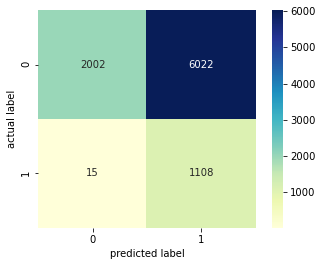

In [23]:
# make a confusion matrix to display the results
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, nb_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

           0       0.99      0.25      0.40      8024
           1       0.16      0.99      0.27      1123

    accuracy                           0.34      9147
   macro avg       0.57      0.62      0.33      9147
weighted avg       0.89      0.34      0.38      9147



In [25]:
# AUC ROC Score
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, nb_preds))

0.6180722081307279


Overall: The NB model has a really low accuracy of around 34%.  The confusion matrix shows a lot of false positives (6,022).  This definitely wouldn't be good for the bank; to think that the marketing campaign was successful so often when it actually isn't would inflate their results and cause them to make bad decisions.  The high false positive occurence is what makes the precision suffer, being 0.16 for trues and 0.89 weighted overall. Conversely, there are very few false negatives. 

This model does not perform well, possibly because of the class imbalance.

The ROC score of 0.62 is the benchmark to compare to models going forward. 

#### Random Forest

In [26]:
# Create the model
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_jobs = -1)
forest_model.fit(x_train,y_train)

#gathering the predictions
forest_preds = forest_model.predict(x_test)

In [27]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,forest_preds))

0.9075106592325353


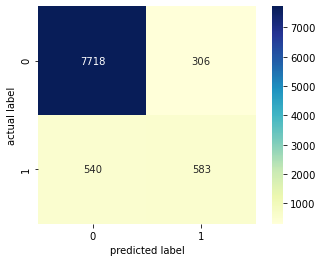

In [28]:
# make a confusion matrix to display the results
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, forest_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, forest_preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      8024
           1       0.66      0.52      0.58      1123

    accuracy                           0.91      9147
   macro avg       0.80      0.74      0.76      9147
weighted avg       0.90      0.91      0.90      9147



In [30]:
# AUC ROC Score
print(roc_auc_score(y_test, forest_preds))

0.7405047768537663


Overall: The RF model has a high accuracy of almsot 91%.  The false postives are much lower compared to the NB model, which is indicated by the confusion matrix and by the higher precicion score (0.66 for trues and 0.90 weighted average).  This model seems to suffer most from a higher proportion of false negatives.  The recall score for trues (1s) is only 0.52.  But in this context, false negatives seem more conservative than false positives.

The AUC score of 0.74 for this model is also higher than the NB model. 

#### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

#gathering the predictions
lr_preds = lr_model.predict(x_test)

In [32]:
#using the sklearn.metrics package to determine the accuracy of the model
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,lr_preds))

0.9022630370613316


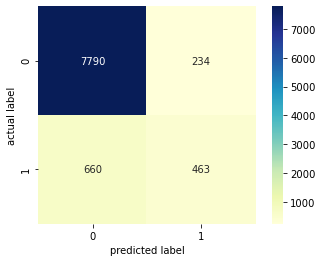

In [33]:
# make a confusion matrix to display the results
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8024
           1       0.66      0.41      0.51      1123

    accuracy                           0.90      9147
   macro avg       0.79      0.69      0.73      9147
weighted avg       0.89      0.90      0.89      9147



In [35]:
print(roc_auc_score(y_test, lr_preds))

0.6915630002246155


Overall: The final model, Logistic Regression, has another high accuracy of 90%.  The false negatives are high (660), leading to the lowest recall of the models.  Conversely, for 1s, the precision is high at 0.66, which ties the random forest. This model had the least false positives.  

The AUC is not as high as the RF however, at 0.69.

### Summary of Results

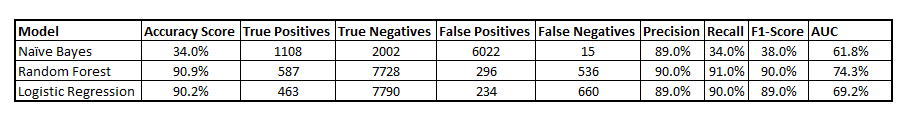

In [36]:
# Display in notebook
from IPython.display import Image
Image(filename='screen2.png')

Random Forest and Logistic Regression had the best accuracies and scores for precision, recall, and F1-Score.  The NB model had a lot of false positives which lowered its precision, recall, and f1 scores.  The AUC score for NB was good though.  F1 is the tradeoff between precision and recall, and is highest for the Random Forest model.

Overall, the best model is the random forest model.  It has the best combination of accuracy, low false positives, high precisiont/recall/f1-scores, and the best AUC score.  I will plot that model below.

### Plotting the ROC Curve of the Best Model

In [45]:
from sklearn.model_selection import cross_val_score, cross_val_predict

lr_proba = cross_val_predict(forest_model, x_train, y_train, cv=3, method='predict_proba')
lr_scores = lr_proba[:, 1]

In [46]:
def ROC_Curve(title, y_train, scores, label=None):
    from sklearn.metrics import roc_curve
    
    # calculate the ROC score
    fpr, tpr, thresholds = roc_curve(y_train, scores)
    print('AUC Score ({}): {:.2f} '.format(title, roc_auc_score(y_train, scores)))
    
    # plot the ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth=2, label=label, color='b')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve: {}'.format(title), fontsize=16)
    plt.show()

AUC Score (Bank Marketing Campaign Success): 0.94 


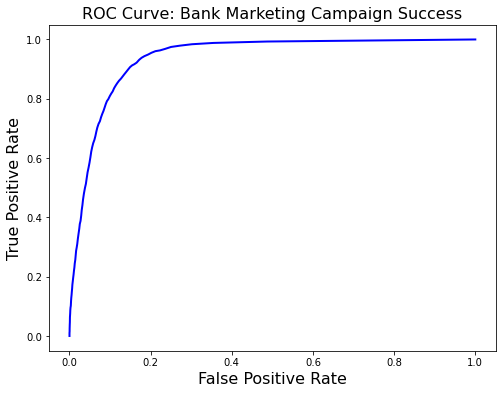

In [47]:
ROC_Curve('Bank Marketing Campaign Success',y_train,lr_scores)

### Choosing the Best Threshold


The curve is useful to understand the trade-off in the true-positive rate and false-positive rate for different thresholds. The area under the ROC Curve provides a single number to summarize the performance of a model in terms of its ROC Curve with a value between 0.5 (no-skill) and 1.0 (perfect skill).  Different points on the curve represent different skill values.

The tradeoff is that as the model gets better at identifying true positives, it also has the risk of predicting false positives.  The optimal point on the curve is where this tradeoff is best - where the model mixes the highest true postive rate with the lowest detriment from false postives.  In the graph, this point is the one on the curve that is closest to the top left corner of the plot.

The tutorial referenced below shows how to find this point.

Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

Best Threshold=0.160000, G-Mean=0.879


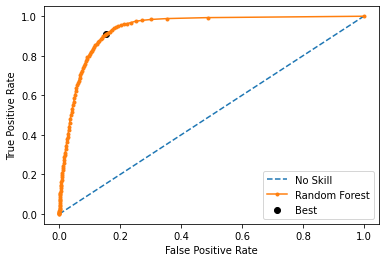

In [50]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr, tpr, thresholds = roc_curve(y_train, lr_scores)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

The optimal point is represented by the black dot.  The best threshold value is where the false positive rate is 0.16.  This is the point where benefit of the effects of predicting true positive, minus the detriments of the risks of making false positive predictions, is highest.  This value is not necessarily the highest point on the curve, just where the net benefit is best.

#### Using XGBoost

[14:49:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9667307061524765
Test accuracy: 0.9082759374658358
ROC AUC: 0.9426823048219545
Test Log Loss: 0.19455090707911252
Test Brier Score: 0.0626660367413081


Text(0.5, 1.0, 'XGBoost Feature Importance with Split Mean Gain')

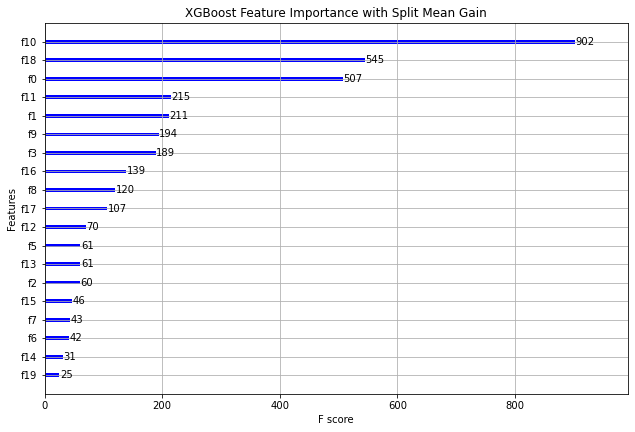

In [23]:
from sklearn.metrics import log_loss, brier_score_loss
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_train)

xgb_pred = xgb.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, xgb_pred)
print("Train accuracy:",xgb.score(x_train, y_train))
print("Test accuracy:", xgb.score(x_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, xgb_pred))
print("Test Log Loss:", log_loss(y_test, xgb_pred))
print("Test Brier Score:", brier_score_loss(y_test, xgb_pred))

# Plot XGBoost default feature importance
fig = plt.figure(figsize = (23, 15))

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='blue')
ax1.set_title("XGBoost Feature Importance with Split Mean Gain")

eXtreme Gradient Boosting gives the best ROC AUC of all the models.  It has an ROC AUC score of 94%.  The plot below shows how good thet ROC curve is.  It is close to the left hand corner of the graph.  The plot above shows the importance of features. F10 has the highest feature importance, and influences the outcome the most. 

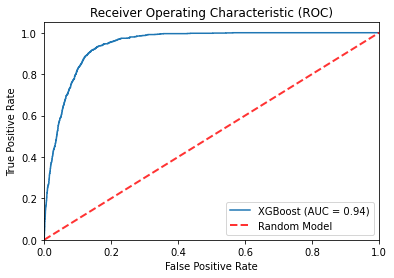

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
xgb_roc_auc = roc_auc_score(y_test, xgb_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_pred)
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Random Model', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()